# Convolutional Neural Networks: Solutions
- 실습조교: 배진수(wlstn215@korea.ac.kr), 김정인(jungin_kim23@korea.ac.kr), 정진용(jy_jeong@korea.ac.kr)

## Colab gpu 연결

#### 런타임 -> 런타임유형 변경 -> 하드웨어 가속기 -> GPU

In [48]:
import torch
torch.cuda.is_available()

False

## 0.모듈 불러오기

In [49]:
''' 기본 모듈 및 시각화 모듈 '''
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

''' 데이터 전처리 모듈 '''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

'''Neural Network을 위한 딥러닝 모듈'''
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

''' 결과 평가용 모듈 '''
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

## 1. 분석데이터 : Fashion-MNIST 의류 이미지

- 이미지 데이터는 픽셀로 이루어져 있으며, 각 픽셀의 밝기(intensity, 0~255)를 통해 이미지를 나타낼 수 있다.
- Fashion-MNIST 데이터는 이런 픽셀 값들을 설명변수(X)로 하여 어떤 의류(Y)에 해당하는 이미지인지 분류하는 문제
- Fashion-MNIST 데이터의 이미지는 가로 28 픽셀, 세로 28 픽셀로 이루어져 있으므로 28 x 28 = 784개의 설명변수로 10개의 클래스를 예측하는 다범주 분류문제
- 해당 데이터에서의 레이블과 클래스는 아래의 표와 같다.

|레이블|클래스|
|---|---|
|0|T-shirt/top(티셔츠)|
|1|Trouser(바지)|
|2|Pullover(스웨터)|
|3|Dress(드레스)|
|4|Coat(코트)|
|5|Sandal(샌들)|
|6|Shirt(셔츠)|
|7|Sneaker(운동화)|
|8|Bag(가방)|
|9|Ankel boot(발목부츠)|

### 데이터 불러오기

In [50]:
data = pd.read_csv("./data/Fashion_MNIST_Example.csv")

## 1.1 탐색적 데이터 분석

### 데이터 확인

In [51]:
## 불러온 데이터의 shape 확인
print('Data shape: {}'.format(data.shape))
data.head()

Data shape: (1000, 785)


,1,2,3,4,5,6,7,8,9,10,...,776,777,778,779,780,781,782,783,784,Y
0,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,41,...,177,163,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,40,122,...,93,87,49,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,...,118,66,0,0,0,0,0,0,0,0


### 클래스 비율 확인

In [52]:
data['Y'].value_counts()

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: Y, dtype: int64

### 예시 이미지 출력

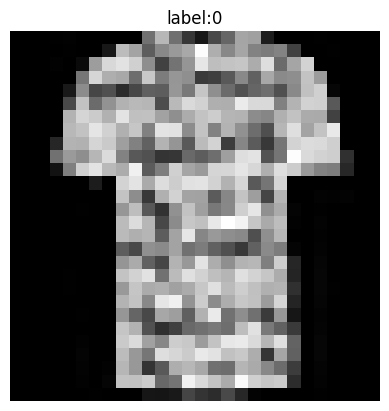

In [53]:
## 1번째 데이터의 예시이미지 출력
image = data.iloc[0,:-1].values
label = data.iloc[0,-1]
plt.imshow(image.reshape(28,28), cmap='gray')
plt.axis('off')
plt.title(f"label:{label}")
plt.show()

## 1-2. 모델링: Convolutional Neural Networks (DNN)

### Dataset

In [54]:
class Fashion_MNISTDataset(Dataset):
    def __init__(self, data_path, split):
        '''데이터 불러오기, 전처리'''

        # 데이터 불러오기
        data = pd.read_csv(data_path)
        X = data.drop(labels='Y', axis=1).values
        y = data['Y'].values

        # 데이터 나누기 (학습, 검증, 테스트)
        train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)
        train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.2, random_state=0)

        # 데이터 정규화
        self.scaler = StandardScaler()
        train_X = self.scaler.fit_transform(train_X)
        valid_X = self.scaler.transform(valid_X)
        test_X = self.scaler.transform(test_X)

        # 데이터셋 지정
        if split == 'train':
            self.data_X = train_X
            self.data_y = train_y
        elif split == 'valid':
            self.data_X = valid_X
            self.data_y = valid_y
        elif split == 'test':
            self.data_X = test_X
            self.data_y = test_y

        # numpy array -> Tensor 변환
        self.data_X = torch.FloatTensor(self.data_X.reshape(-1,1,28,28))
        self.data_y = torch.LongTensor(self.data_y)

    def __len__(self):
        '''데이터셋 개수 정의'''
        return len(self.data_X)
    
    def __getitem__(self, idx):
        '''인덱스를 입력받아 데이터를 출력'''
        X = self.data_X[idx]
        y = self.data_y[idx]
        return X, y

#### DataLoader

In [55]:
# 학습 데이터
train_dataset = Fashion_MNISTDataset(data_path='./data/Fashion_MNIST_Example.csv', split='train')
train_loader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)
# 검증 데이터
valid_dataset = Fashion_MNISTDataset(data_path='./data/Fashion_MNIST_Example.csv', split='valid')
valid_loader = DataLoader(dataset = valid_dataset, batch_size = 64)
# 테스트 데이터
test_dataset = Fashion_MNISTDataset(data_path='./data/Fashion_MNIST_Example.csv', split='test')
test_loader = DataLoader(dataset = test_dataset, batch_size = 64)

### Model

In [56]:
class CNN(torch.nn.Module):
    def __init__(self, input_channel, num_classes=10): 
        super().__init__()
        
        ''' 모델에 필요한 layer 정의 ''' 
               
        self.conv1 = torch.nn.Conv2d(1,32,kernel_size=2)
        self.conv2 = torch.nn.Conv2d(32,64,kernel_size=2)
        self.conv3 = torch.nn.Conv2d(64,128,kernel_size=2)        
        
        self.max_pool_2d = torch.nn.MaxPool2d(kernel_size=2)
        
        self.relu = torch.nn.ReLU() # Relu activation function
        
        self.linear = torch.nn.Linear(512, num_classes)
        
    def forward(self, x):
        
        ''' x를 입력받아 진행할 순서 설정 '''

        x = self.max_pool_2d(self.relu(self.conv1(x)))
        x = self.max_pool_2d(self.relu(self.conv2(x)))
        x = self.max_pool_2d(self.relu(self.conv3(x)))        

        x = x.view(x.size(0),-1)
        logit = self.linear(x)

        return logit

In [57]:
# 입력 채널 개수
input_channel = train_dataset.data_X.shape[1]
# 모델 선언
model = CNN(input_channel, num_classes=10) # 10=class 개수

### 비용함수

In [58]:
# 비용함수 정의 (분류문제 -> crossentropy 사용)
criterion = torch.nn.CrossEntropyLoss()

### Optimizer

In [59]:
# 경사하강법의 종류 정의 (adam)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)

### 학습

In [62]:
# gpu 사용
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# gpu에서 모델 동작
model.to(device)

num_epochs = 100

print("Start Training !")
print('-'*50)

train_loss_total = []
valid_loss_total = []
best_loss = np.inf

for epoch in range(num_epochs):
    
    train_loss = 0
    valid_loss = 0
    
    ''' Training '''
    # 모델을 학습모드로 전환
    model.train()
    # __getitem__에서 반환해주는 형태로 데이터 반환
    for X_data, y_data in train_loader:

        # 데이터를 gpu로
        X_data = X_data.to(device)
        y_data = y_data.to(device)
        
        # 모델의 모든 기울기 값을 0으로 설정
        optim.zero_grad()
        
        # 데이터를 모델에 입력하여 출력값 계산
        y_pred = model(X_data)
        
        # 비용함수를 활용하여 오차 계산
        loss = criterion(y_pred, y_data)
        
        # 계산된 오차를 기반으로 기울기 계산
        loss.backward()
        
        # 계산된 기울기를 바탕으로 모델의 파라미터 업데이트
        optim.step()

        train_loss += loss.item()
    
    ''' Validation '''
    # 모델을 평가모드로 전환
    model.eval()
    # 모델을 평가할때는 기울기 계산 불필요
    with torch.no_grad():
        for X_data, y_data in valid_loader:
            # 데이터를 gpu로
            X_data = X_data.to(device)
            y_data = y_data.to(device)
            y_pred = model(X_data)
            loss = criterion(y_pred, y_data)
            valid_loss += loss.item()
    
    # epoch의 loss 계산
    train_loss_epoch = train_loss/len(train_loader)
    valid_loss_epoch = valid_loss/len(valid_loader)

    print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {valid_loss_epoch:.3f}')
    
    # validation loss 기준으로 best epoch 계산 (Early stopping)
    if valid_loss_epoch < best_loss:
        # best loss 업데이트
        best_loss = valid_loss_epoch
        # 최적의 epoch 수와 모델 저장하기
        best_epoch = epoch
        torch.save(model.state_dict(), './best_model_cnn_fashion_MNIST.pt')
    
    train_loss_total.append(train_loss_epoch)
    valid_loss_total.append(valid_loss_epoch)
    
print('-'*50)
print(f'Finished Training ! Best Epoch is epoch {best_epoch+1}')

Start Training !
--------------------------------------------------
1 epoch | Train loss: 0.399, Valid loss: 0.662
2 epoch | Train loss: 0.402, Valid loss: 0.656
3 epoch | Train loss: 0.394, Valid loss: 0.664
4 epoch | Train loss: 0.392, Valid loss: 0.649
5 epoch | Train loss: 0.388, Valid loss: 0.654
6 epoch | Train loss: 0.387, Valid loss: 0.656
7 epoch | Train loss: 0.381, Valid loss: 0.654
8 epoch | Train loss: 0.377, Valid loss: 0.653
9 epoch | Train loss: 0.375, Valid loss: 0.651
10 epoch | Train loss: 0.374, Valid loss: 0.651
11 epoch | Train loss: 0.374, Valid loss: 0.651
12 epoch | Train loss: 0.370, Valid loss: 0.655
13 epoch | Train loss: 0.364, Valid loss: 0.665
14 epoch | Train loss: 0.366, Valid loss: 0.644
15 epoch | Train loss: 0.363, Valid loss: 0.657
16 epoch | Train loss: 0.355, Valid loss: 0.650
17 epoch | Train loss: 0.356, Valid loss: 0.651
18 epoch | Train loss: 0.358, Valid loss: 0.656
19 epoch | Train loss: 0.348, Valid loss: 0.646
20 epoch | Train loss: 0.349,

### 학습 상태 확인 (learning curve)

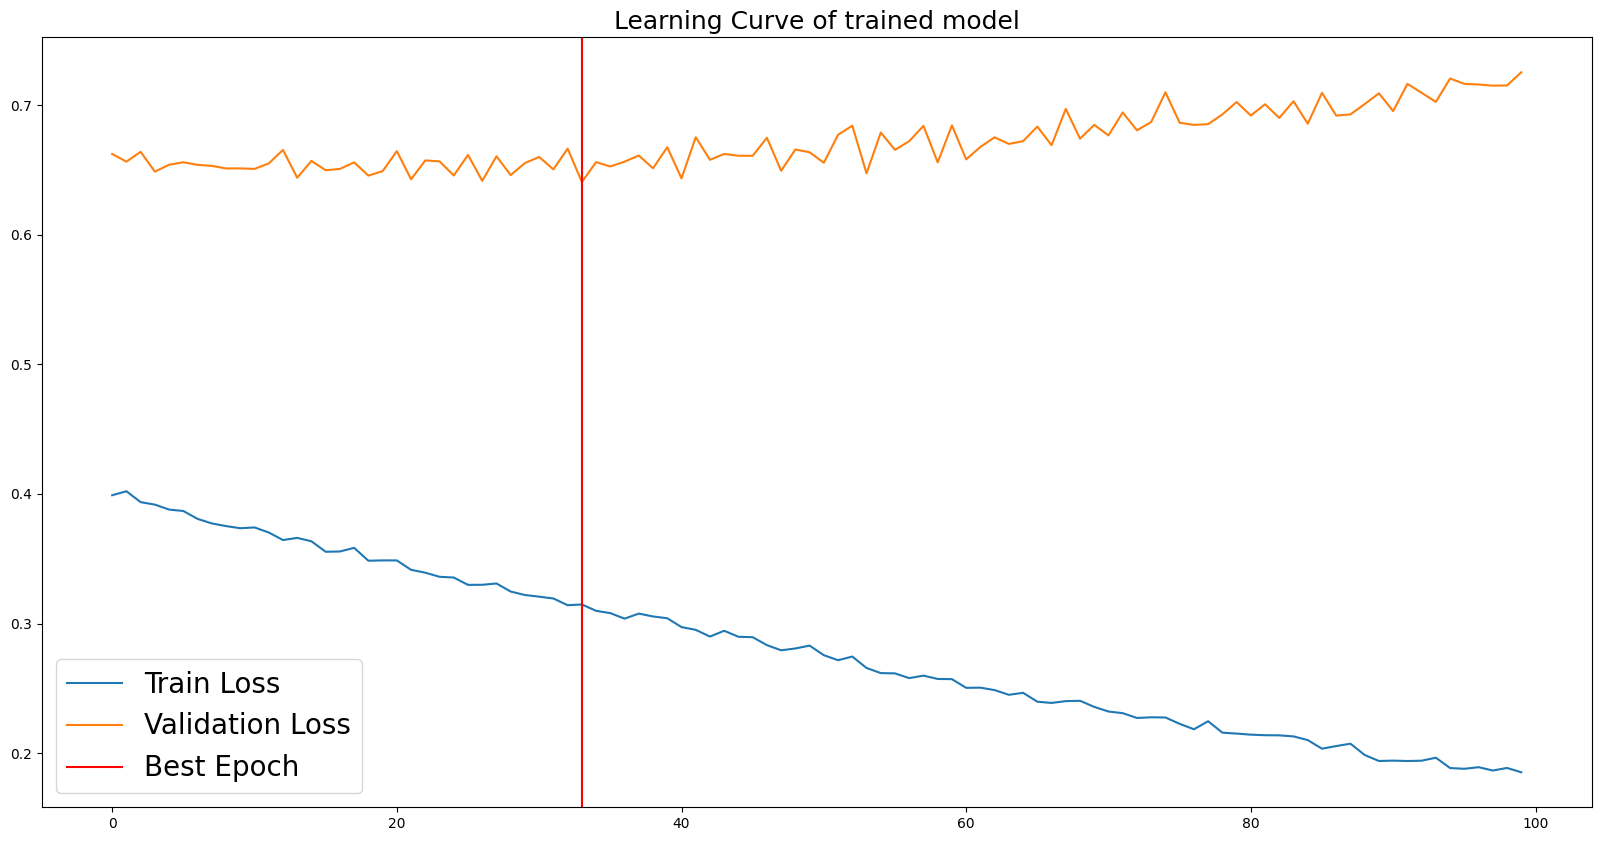

In [63]:
plt.figure(figsize=(20,10))

# 학습 및 검증 로스 변동 관찰하기
plt.plot(train_loss_total,label='Train Loss')
plt.plot(valid_loss_total, label='Validation Loss')
# 최적의 모델이 저장된 곳 표시
plt.axvline(x = best_epoch, color='red', label='Best Epoch')
plt.legend(fontsize=20)
plt.title("Learning Curve of trained model", fontsize=18)
plt.show()

## 1-3. Deep Neural Networks 모델 성능 평가

In [65]:
# 모델 선언
model = CNN(input_channel, num_classes=10) # 10=class 개수

# 최적의 모델 불러오기
ckpt = torch.load('./best_model_cnn_fashion_MNIST.pt')

# 모델 파라미터 불러오기
model.load_state_dict(ckpt)

<All keys matched successfully>

### 학습된 DNN 결과 확인 및 성능 평가: Training Data

In [66]:
# model을 evaluation 모드로 변경
pred_list = []
true_list = []

model.eval()
with torch.no_grad():
    for X_data, y_data in train_loader:
        # 모델의 출력값 계산
        y_logit = model(X_data)
        # 출력값을 최대로하는 인덱스(class) 저장
        y_pred = torch.argmax(y_logit, dim=1)
        # 예측값과 실제값 저장
        pred_list.extend(y_pred.detach().numpy())
        true_list.extend(y_data.detach().numpy())

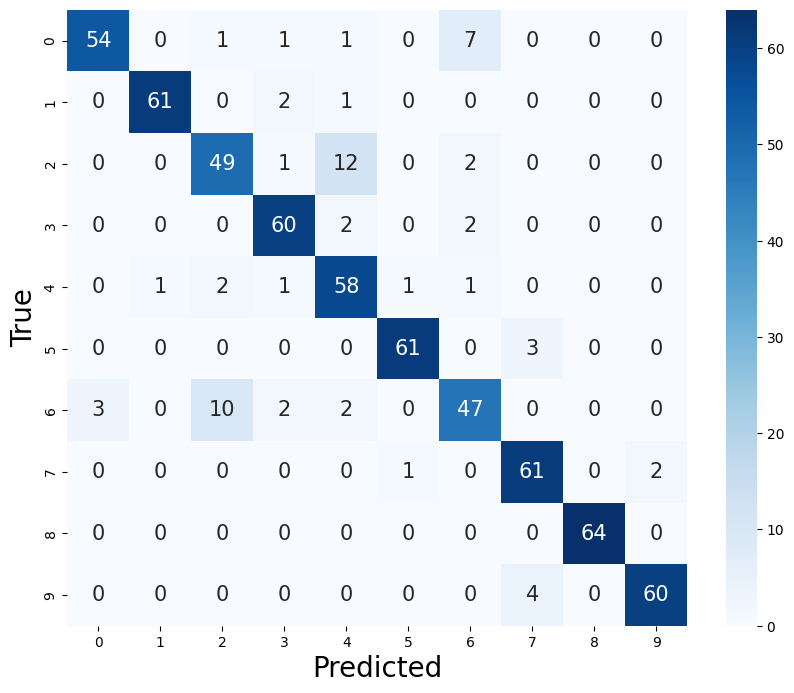

Train Accuracy   : 0.898
Train Sensitivity: 0.898
Train Precision  : 0.901
Train F1 Score   : 0.898


In [67]:
# confusion matrix 계산
cm_train = confusion_matrix(y_true=true_list, y_pred=pred_list)

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_train, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

# 평가지표 계산
train_acc = accuracy_score(true_list, pred_list)
train_rec = recall_score(true_list, pred_list, average='macro')
train_prec = precision_score(true_list, pred_list, average='macro')
train_f1 = f1_score(true_list, pred_list, average='macro')

print('Train Accuracy   : {:.3f}'.format(train_acc))
print('Train Sensitivity: {:.3f}'.format(train_rec))
print('Train Precision  : {:.3f}'.format(train_prec))
print('Train F1 Score   : {:.3f}'.format(train_f1))

### 학습된 DNN 결과 확인 및 성능 평가: Testing Data

In [68]:
# model을 evaluation 모드로 변경
pred_list = []
true_list = []

model.eval()
with torch.no_grad():
    for X_data, y_data in test_loader:
        # 모델의 출력값 계산
        y_logit = model(X_data)
        # 출력값을 최대로하는 인덱스(class) 저장
        y_pred = torch.argmax(y_logit, dim=1)
        # 예측값과 실제값 저장
        pred_list.extend(y_pred.detach().numpy())
        true_list.extend(y_data.detach().numpy())

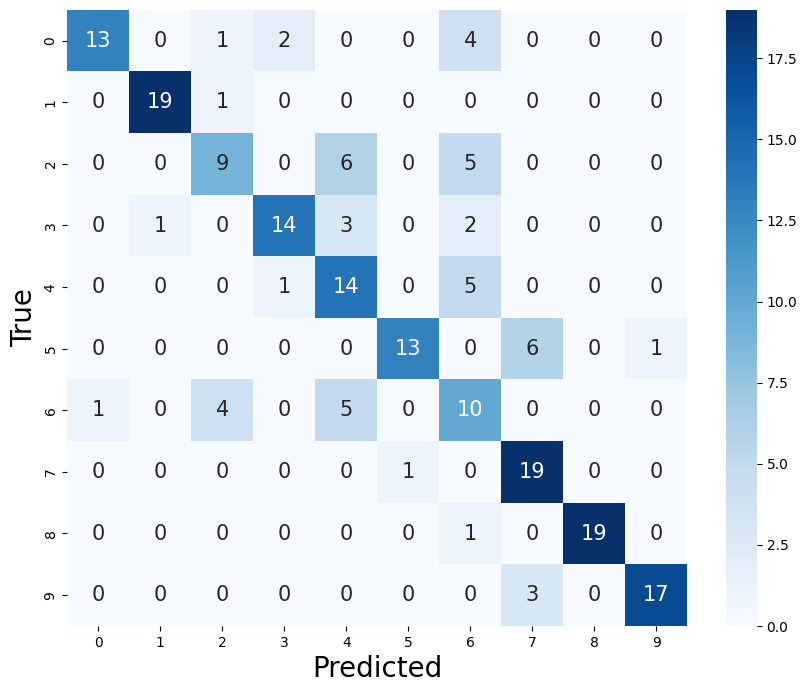

Test Accuracy   : 0.735
Test Sensitivity: 0.735
Test Precision  : 0.772
Test F1 Score   : 0.742


In [69]:
# confusion matrix 계산
cm_train = confusion_matrix(y_true=true_list, y_pred=pred_list)

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_train, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

# 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_rec = recall_score(true_list, pred_list, average='macro')
test_prec = precision_score(true_list, pred_list, average='macro')
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

## 1-4. 실제 데이터 이미지로 확인

|레이블|클래스|
|---|---|
|0|T-shirt/top(티셔츠)|
|1|Trouser(바지)|
|2|Pullover(스웨터)|
|3|Dress(드레스)|
|4|Coat(코트)|
|5|Sandal(샌들)|
|6|Shirt(셔츠)|
|7|Sneaker(운동화)|
|8|Bag(가방)|
|9|Ankel boot(발목부츠)|

In [73]:
# test data에서 일부 이미지 선택 및 해당 레이블 확인
test_data = test_dataset.data_X[:9]
y_true = test_dataset.data_y[:9]

# 모델의 출력값 계산
y_logit = model(test_data)

# 출력값을 최대로하는 인덱스(class) 저장
y_pred = torch.argmax(y_logit, dim=1)

# scaler 불러오기
scaler = test_dataset.scaler

# 정규화 제거 (-1 ~ 1 -> 0 ~ 255)
test_data = scaler.inverse_transform(test_data.reshape(test_data.shape[0],-1))

예측값 출력
tensor([[2, 7, 2],
        [7, 7, 1],
        [4, 5, 3]])
실제값 출력
tensor([[2, 7, 2],
        [9, 7, 1],
        [4, 5, 3]])


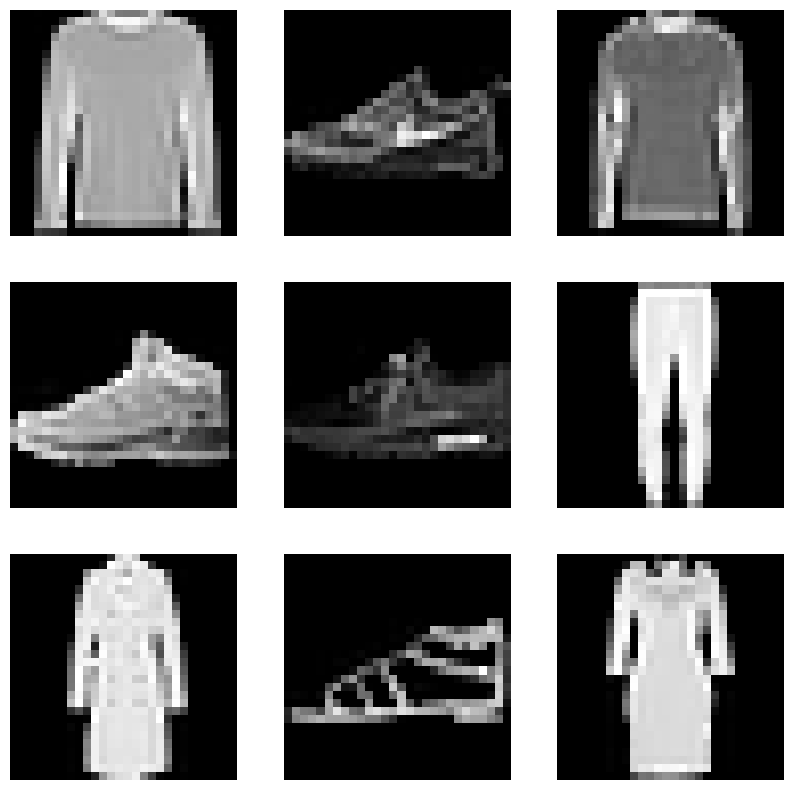

In [74]:
# 예측값 출력
print('예측값 출력')
print(y_pred.reshape(3,3))

print('실제값 출력')
print(y_true.reshape(3,3))

# test data 시각화
fig ,axes = plt.subplots(3,3,figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(test_data[i].reshape(28,28), cmap='gray')
    ax.axis('off')
plt.show()